In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import csv
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
examples = []
labels = []


participant_folders = glob.glob("data/Participant_*")

for folder in participant_folders:
    participant = os.path.basename(folder)  # e.g. "Participant_1"

    
    results_files = glob.glob(os.path.join(folder, f"{participant}_results.csv"))
    if not results_files:
        print(f" No results file found in {participant}")
        continue

    data_path_lst = pd.read_csv(results_files[0])

    
    data_files = glob.glob(os.path.join(folder, "*.csv"))
    data_files = [f for f in data_files if not f.endswith("_results.csv")]

    for fname in data_files:
        base = os.path.basename(fname).replace(".csv", "")

        # ex: "trialA_pap_A_01.csv"
        parts = base.split("_")
        if len(parts) == 4:
            _, Condition, Subcondition, Trial = parts

            
            if "pap" in Condition:
                Condition = Condition.replace("pap", "PAP")
            if "camera" in Condition:
                Condition = Condition.replace("camera", "Camera")

            
            row = data_path_lst[
                (data_path_lst["Condition"] == Condition)
                & (data_path_lst["Subcondition"] == Subcondition)
                & (data_path_lst["Trial"] == Trial)
            ]

            if row.empty:
                print(f"no matching metadata: {participant}/{base}")
            

            else:
            
                df = pd.read_csv(fname)
                if "Device 0 - Follower 0" in df.columns and "Device 0 - Follower 1" in df.columns:
                    example = df[["Device 0 - Follower 0", "Device 0 - Follower 1"]].copy()
                    label = row[["Sensor1 Mean", "Sensor2 Mean"]].values.flatten().tolist()
                    examples.append(example.fillna(0))
                    labels.append(label)

print(f"Total examples collected before preprocessing: {len(examples)}")
print(f"Total labels collected before preprocessing: {len(labels)}")



# delete ['x','x']
valid_examples = []
valid_labels = []

for e, l in zip(examples, labels):
    if any(str(x).lower() == 'x' for x in l):
        continue  
    valid_examples.append(e)
    valid_labels.append(l)

print(f"Total examples collected after preprocessing: {len(valid_examples)}")
print(f"Total labels collected after preprocessing: {len(valid_labels)}")

no matching metadata: Participant_8/Participant_8_results_old
no matching metadata: Participant_6/3_training_NOhaptics_2
 No results file found in Participant_5
no matching metadata: Participant_22/10_camera_HAPTICS_ 1
no matching metadata: Participant_22/10_camera_HAPTICS_ 3
no matching metadata: Participant_22/10_camera_HAPTICS_ 2
no matching metadata: Participant_22/10_camera_HAPTICS_ 5
no matching metadata: Participant_22/10_camera_HAPTICS_ 4
no matching metadata: Participant_13/9_camera_NOhaptics_1
no matching metadata: Participant_13/9_camera_NOhaptics_2
no matching metadata: Participant_13/9_camera_NOhaptics_3
no matching metadata: Participant_13/9_camera_NOhaptics_4
no matching metadata: Participant_13/9_camera_NOhaptics_5
no matching metadata: Participant_13/10_camera_HAPTICS_4
no matching metadata: Participant_13/10_camera_HAPTICS_5
no matching metadata: Participant_13/10_camera_HAPTICS_1
no matching metadata: Participant_13/10_camera_HAPTICS_2
no matching metadata: Participa

In [4]:
# train+temp / test  : 85/15 
ex_train, ex_temp, y_train, y_temp = train_test_split(
    valid_examples, valid_labels, test_size=0.15, random_state=42
)
# train / dev  : 0.85 * 0.176 = 0.15 : 70/15/15
ex_train, ex_dev, y_train, y_dev = train_test_split(
    ex_train, y_train, test_size=0.176, random_state=42
)

print(f"Train: {len(ex_train)}, Dev: {len(ex_dev)}, Test: {len(ex_temp)}")


Train: 426, Dev: 92, Test: 92


In [10]:
# def normalize_examples(example_list, scaler=None):
#     scaled_tensors = []
#     if scaler is None:
#         scaler = StandardScaler()
#         for e in example_list:
#             scaled = scaler.fit_transform(e.values.astype(float))
#             scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
#         return scaled_tensors, scaler
#     else:
#         for e in example_list:
#             scaled = scaler.transform(e.values.astype(float))
#             scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
#         return scaled_tensors

# def pad_tensor_list(tensor_list):
#     seq_lengths = torch.tensor([x.size(0) for x in tensor_list])
#     padded = pad_sequence(tensor_list, batch_first=True, padding_value=0.0)
#     return padded, seq_lengths

# def make_windows_from_examples(example_list, labels, window_size=100, step=10):
#     windowed_examples = []
#     windowed_labels = []
#     for e, y in zip(example_list, labels):
#         arr = e.values.astype(float)
#         n = len(arr)
#         if n < window_size:
#             continue  # 너무 짧은 시퀀스는 건너뜀
#         for start in range(0, n - window_size + 1, step):
#             end = start + window_size
#             windowed_examples.append(arr[start:end])
#             windowed_labels.append(y)
#     return windowed_examples, np.array(windowed_labels, dtype=float)

# def normalize_examples(example_list, scaler=None):
#     scaled_tensors = []
#     if scaler is None:
#         scaler = StandardScaler()
#         all_data = np.vstack([e for e in example_list])  # 전체 데이터로 fit
#         scaler.fit(all_data)
#     for e in example_list:
#         scaled = scaler.transform(e)
#         scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
#     return scaled_tensors, scaler



In [23]:
def make_windows_from_examples(example_list, labels, window_size=150, step=30):
    """
    각 example(DataFrame)을 window_size 단위로 자르고,
    각 window에 대해 label 하나(y)를 붙여 반환.
    """
    windowed_examples, windowed_labels = [], []

    for e, y in zip(example_list, labels):
        arr = e.values.astype(float)
        n = len(arr)
        if n < window_size:
            continue  # 너무 짧은 데이터는 스킵
        for start in range(0, n - window_size + 1, step):
            end = start + window_size
            windowed_examples.append(arr[start:end])
            windowed_labels.append(y)

    # 🔍 길이 불일치 방지
    assert len(windowed_examples) == len(windowed_labels), "❌ Window-label mismatch!"

    return windowed_examples, np.array(windowed_labels, dtype=float)


# =========================================================
# 2. 입력 normalization (StandardScaler)
# =========================================================
def normalize_examples(example_list, scaler=None):
    scaled_tensors = []
    if scaler is None:
        scaler = StandardScaler()
        all_data = np.vstack(example_list)
        scaler.fit(all_data)

    for e in example_list:
        scaled = scaler.transform(e)
        scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))

    return scaled_tensors, scaler


# =========================================================
# 3. 시퀀스 패딩 (길이 맞추기)
# =========================================================
def pad_tensor_list(tensor_list):
    seq_lengths = torch.tensor([x.size(0) for x in tensor_list])
    padded = pad_sequence(tensor_list, batch_first=True, padding_value=0.0)
    return padded, seq_lengths


# =========================================================
# 4. 전체 파이프라인
# =========================================================
WINDOW_SIZE = 150
STEP_SIZE = 150
BATCH_SIZE = 32

# --- 1) window 생성 ---
train_wins, y_train_win = make_windows_from_examples(ex_train, y_train, WINDOW_SIZE, STEP_SIZE)
dev_wins,   y_dev_win   = make_windows_from_examples(ex_dev,   y_dev,   WINDOW_SIZE, STEP_SIZE)
test_wins,  y_test_win  = make_windows_from_examples(ex_temp,  y_temp,  WINDOW_SIZE, STEP_SIZE)

print(f"Train windows: {len(train_wins)}, Dev: {len(dev_wins)}, Test: {len(test_wins)}")

# --- 2) 입력 정규화 ---
train_examples, ex_scaler = normalize_examples(train_wins)
dev_examples, _ = normalize_examples(dev_wins, ex_scaler)
test_examples, _ = normalize_examples(test_wins, ex_scaler)

# --- 3) 출력 정규화 ---
scaler_y = StandardScaler()
scaler_y.fit(y_train_win)  
y_train_scaled = torch.tensor(scaler_y.transform(y_train_win), dtype=torch.float32)
y_dev_scaled   = torch.tensor(scaler_y.transform(y_dev_win), dtype=torch.float32)
y_test_scaled  = torch.tensor(scaler_y.transform(y_test_win), dtype=torch.float32)

# --- 4) 패딩 ---
padded_train, len_train = pad_tensor_list(train_examples)
padded_dev,   len_dev   = pad_tensor_list(dev_examples)
padded_test,  len_test  = pad_tensor_list(test_examples)

# 🔍 크기 확인 (shape mismatch 방지)
print(f"padded_train: {padded_train.shape}, y_train_scaled: {y_train_scaled.shape}, len_train: {len_train.shape}")

min_len = min(padded_train.shape[0], y_train_scaled.shape[0], len_train.shape[0])
padded_train = padded_train[:min_len]
y_train_scaled = y_train_scaled[:min_len]
len_train = len_train[:min_len]

min_len = min(padded_dev.shape[0], y_dev_scaled.shape[0], len_dev.shape[0])
padded_dev = padded_dev[:min_len]
y_dev_scaled = y_dev_scaled[:min_len]
len_dev = len_dev[:min_len]

min_len = min(padded_test.shape[0], y_test_scaled.shape[0], len_test.shape[0])
padded_test = padded_test[:min_len]
y_test_scaled = y_test_scaled[:min_len]
len_test = len_test[:min_len]

# --- 5) Dataset & Dataloader ---
train_dataset = TensorDataset(padded_train, y_train_scaled, len_train)
dev_dataset   = TensorDataset(padded_dev,   y_dev_scaled,   len_dev)
test_dataset  = TensorDataset(padded_test,  y_test_scaled,  len_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# --- 6) 요약 출력 ---
print("\n✅ Dataset & Loader Summary")
print("----------------------------------")
print(f"Train -> Examples: {len(train_dataset)}, Batches: {len(train_loader)}")
print(f"Dev   -> Examples: {len(dev_dataset)}, Batches: {len(dev_loader)}")
print(f"Test  -> Examples: {len(test_dataset)}, Batches: {len(test_loader)}")
print("----------------------------------")
print(f"Train tensor shape: {padded_train.shape}")
print(f"Dev tensor shape:   {padded_dev.shape}")
print(f"Test tensor shape:  {padded_test.shape}")

Train windows: 2011, Dev: 441, Test: 404
padded_train: torch.Size([2011, 150, 2]), y_train_scaled: torch.Size([2011, 2]), len_train: torch.Size([2011])

✅ Dataset & Loader Summary
----------------------------------
Train -> Examples: 2011, Batches: 63
Dev   -> Examples: 441, Batches: 14
Test  -> Examples: 404, Batches: 13
----------------------------------
Train tensor shape: torch.Size([2011, 150, 2])
Dev tensor shape:   torch.Size([441, 150, 2])
Test tensor shape:  torch.Size([404, 150, 2])


In [24]:
# # example normalization
# train_examples, ex_scaler = normalize_examples(ex_train)
# dev_examples = normalize_examples(ex_dev, ex_scaler)
# test_examples = normalize_examples(ex_temp, ex_scaler)

# # label normalization (train 기준으로 fit)
# scaler_y = StandardScaler()
# y_train_arr = np.array(y_train, dtype=float)
# y_dev_arr = np.array(y_dev, dtype=float)
# y_test_arr = np.array(y_temp, dtype=float)

# scaler_y.fit(y_train_arr)
# y_train_scaled = torch.tensor(scaler_y.transform(y_train_arr), dtype=torch.float32)
# y_dev_scaled = torch.tensor(scaler_y.transform(y_dev_arr), dtype=torch.float32)
# y_test_scaled = torch.tensor(scaler_y.transform(y_test_arr), dtype=torch.float32)

# padded_train, len_train = pad_tensor_list(train_examples)
# padded_dev, len_dev = pad_tensor_list(dev_examples)
# padded_test, len_test = pad_tensor_list(test_examples)

# train_dataset = TensorDataset(padded_train, y_train_scaled, len_train)
# dev_dataset   = TensorDataset(padded_dev, y_dev_scaled, len_dev)
# test_dataset  = TensorDataset(padded_test, y_test_scaled, len_test)

# batch_size = 8
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# dev_loader   = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print("Dataset & Loader Shapes Summary")
# print("----------------------------------")
# print(f"Train set ->  Examples: {len(train_dataset)},  Labels: {y_train_scaled.shape},  "
#       f"Batches: {len(train_loader)} (batch_size={batch_size})")
# print(f"Dev set   ->  Examples: {len(dev_dataset)},   Labels: {y_dev_scaled.shape},  "
#       f"Batches: {len(dev_loader)} (batch_size={batch_size})")
# print(f"Test set  ->  Examples: {len(test_dataset)},  Labels: {y_test_scaled.shape},  "
#       f"Batches: {len(test_loader)} (batch_size={batch_size})")
# print("----------------------------------")
# print(f"Train tensor shape: {padded_train.shape}")
# print(f"Dev tensor shape:   {padded_dev.shape}")
# print(f"Test tensor shape:  {padded_test.shape}")



In [25]:
padded_train[0].shape

torch.Size([150, 2])

In [26]:
if torch.backends.mps.is_available():      # M1/M2 GPU
    device = torch.device("mps")
elif torch.cuda.is_available():            # NVIDIA GPU
    device = torch.device("cuda")
else:                                      # CPU fallback
    device = torch.device("cpu")

print(f" Using device: {device}")

 Using device: mps


In [47]:
class PressureRNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, num_layers=2, dropout = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        # 마지막 실제 timestep의 hidden state 선택
        out = out[torch.arange(len(lengths)), lengths - 1, :]
        # out = self.norm(out)
        out = self.fc(out)
        return out


In [48]:

def train_model(model, train_loader, dev_loader, criterion, optimizer,
                device, n_epochs=50, log_interval=5, clip_norm=1.0,
                save_dir="./results/weights"):

    # --- Save directory ---
    os.makedirs(save_dir, exist_ok=True)

    train_losses = []
    dev_losses = []
    best_dev_loss = float('inf')

    # 현재 시간 태그 (ex: 2025-11-07_14-25)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0

        # --- Training ---
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)
        for batch_x, batch_y, batch_len in progress:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x, batch_len)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
            optimizer.step()

            total_train_loss += loss.item() * batch_x.size(0)
            progress.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # --- Validation ---
        model.eval()
        total_dev_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y, batch_len in dev_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                dev_outputs = model(batch_x, batch_len)
                dev_loss = criterion(dev_outputs, batch_y)
                total_dev_loss += dev_loss.item() * batch_x.size(0)
        avg_dev_loss = total_dev_loss / len(dev_loader.dataset)
        dev_losses.append(avg_dev_loss)

        # --- Logging ---
        if (epoch + 1) % log_interval == 0 or epoch == 0:
            tqdm.write(f"Epoch [{epoch+1:>2}/{n_epochs}] | "
                       f"Train Loss: {avg_train_loss:.6f} | Dev Loss: {avg_dev_loss:.6f}")

        # --- Save best model ---
        if avg_dev_loss < best_dev_loss:
            best_dev_loss = avg_dev_loss
            best_model_state = model.state_dict()  # 파일로 안 쓰고 메모리에만 보관


    # --- Save only once, at the end ---
    best_name = f"best_pressureRNN_{timestamp}_loss{best_dev_loss:.4f}.pth"
    best_path = os.path.join(save_dir, best_name)
    torch.save(best_model_state, best_path)
    print(f"💾 Saved only the best model once → {best_name}")

    # (optional) final model도 따로 저장
    final_name = f"final_pressureRNN_{timestamp}_epoch{n_epochs}_loss{avg_dev_loss:.4f}.pth"
    torch.save(model.state_dict(), os.path.join(save_dir, final_name))

    return train_losses, dev_losses


def plot_now(n_epochs, train_losses, dev_losses):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss', linewidth=2)
    plt.plot(range(1, n_epochs+1), dev_losses, label='Dev Loss', linewidth=2, linestyle='--')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title('Training vs Dev Loss Curve', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [ ]:
input_dim, output_dim = 2, 2
hidden_dim = 64
num_layers = 10
dropout = 0
n_epochs = 100

model = PressureRNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout = dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, dev_losses = train_model(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
    log_interval=1
)

plot_now(n_epochs, train_losses, dev_losses)

Epoch 1/100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch [ 1/100] | Train Loss: 1.002263 | Dev Loss: 0.947819


Epoch 2/100:  14%|█▍        | 9/63 [00:10<01:05,  1.21s/it, batch_loss=0.7878]

In [ ]:




def log_experiment(params):
    log_path = os.path.join("results", "experiment_logs.csv")
    file_exists = os.path.exists(log_path)
    with open(log_path, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=params.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(params)

def save_loss_plot(train_losses, dev_losses, title, filename):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(dev_losses, label="Dev Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f" Saved loss plot: {filename}")

def summarize_model(model: torch.nn.Module):
    lines = []
    for name, layer in model.named_children():
        layer_str = str(layer).replace("\n", "")
        lines.append(f"{name}: {layer_str}")
    return " → ".join(lines)

log_path = os.path.join("results", "experiment_logs.csv")
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

params = {
    "timestamp": timestamp,
    "architecture": summarize_model(model),
    "hidden_dim": model.lstm.hidden_size,
    "num_layers": model.lstm.num_layers,
    "dropout": 0.3,
    "learning_rate": 1e-3,
    "batch_size": 8,
    "n_epochs": 50,
    "train_size": len(train_loader.dataset),
    "dev_size": len(dev_loader.dataset),
    "final_train_loss": round(train_losses[-1], 6),
    "final_dev_loss": round(dev_losses[-1], 6),
    "best_dev_loss": round(min(dev_losses), 6),
    "best_epoch": int(dev_losses.index(min(dev_losses)) + 1),
    "optimizer": "Adam",
    "notes": " "
}

plot_filename = os.path.join("results", "plots", f"loss_curve_{timestamp}.png")


save_loss_plot(
    train_losses, 
    dev_losses, 
    title=f"Training vs Dev Loss ({timestamp})",
    filename=plot_filename
)

log_experiment(params)
print(f"Experiment logged to {log_path}")


 Saved loss plot: results/plots/loss_curve_2025-11-08_02-41-36.png
Experiment logged to results/experiment_logs.csv


In [42]:
df = pd.read_csv("/Users/jeongjuhyeon/Desktop/Python/CS230-Project/results/experiment_logs.csv")
df

,timestamp,architecture,hidden_dim,num_layers,dropout,learning_rate,batch_size,n_epochs,train_size,dev_size,final_train_loss,final_dev_loss,best_dev_loss,best_epoch,optimizer,notes
0,2025-11-07_12-08-20,"lstm: LSTM(2, 64, batch_first=True, dropout=0....",64,1,0.3,0.001,8,50,426,92,0.702152,1.341566,0.998132,2,Adam,
1,2025-11-07_14-45-47,"lstm: LSTM(2, 64, num_layers=2, batch_first=Tr...",64,2,0.3,0.001,8,50,426,92,1.007214,1.024324,0.976938,3,Adam,
2,2025-11-07_15-35-03,"lstm: LSTM(2, 64, num_layers=2, batch_first=Tr...",64,2,0.3,0.001,8,50,426,92,0.991216,0.981362,0.980815,4,Adam,
3,2025-11-08_02-12-33,"lstm: LSTM(2, 64, num_layers=2, batch_first=Tr...",64,2,0.3,0.001,8,50,2011,441,0.836411,0.800664,0.800664,50,Adam,
4,2025-11-08_02-41-16,"lstm: LSTM(2, 64, num_layers=2, batch_first=Tr...",64,2,0.3,0.001,8,50,2011,441,0.809016,0.833118,0.797282,85,Adam,
5,2025-11-08_02-41-36,"lstm: LSTM(2, 64, num_layers=2, batch_first=Tr...",64,2,0.3,0.001,8,50,2011,441,0.809016,0.833118,0.797282,85,Adam,


In [43]:
def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch_x, batch_y, batch_len in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x, batch_len)
            preds.append(outputs.cpu().numpy())
            trues.append(batch_y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    mse = np.mean((preds - trues) ** 2)
    rmse = np.sqrt(mse)

    print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    return preds, trues

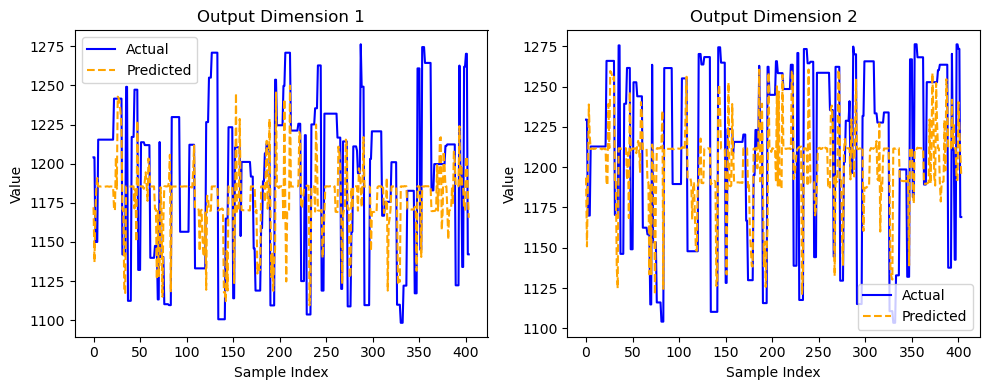

In [40]:
def evaluate_and_plot(model, test_loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch_x, batch_y, batch_len in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x, batch_len)
            preds.append(outputs.cpu().numpy())
            trues.append(batch_y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return preds, trues


# -------------------------------
# 2️⃣ 예측 수행
# -------------------------------
preds, trues = evaluate_and_plot(model, test_loader, device)

# -------------------------------
# 3️⃣ inverse normalization (StandardScaler 사용 시)
# -------------------------------
# 학습할 때 사용했던 scaler를 그대로 사용해야 함
# 예: scaler_y = StandardScaler().fit(train_y)
preds_original = scaler_y.inverse_transform(preds)
trues_original = scaler_y.inverse_transform(trues)

# -------------------------------
# 4️⃣ Plot
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i, ax in enumerate(axes):
    ax.plot(trues_original[:, i], label="Actual", color='blue')
    ax.plot(preds_original[:, i], label="Predicted", color='orange', linestyle='--')
    ax.set_title(f"Output Dimension {i+1}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

In [45]:
model.eval()
all_preds, all_trues = [], []

with torch.no_grad():
    for xb, yb, lb in dev_loader:
        xb, lb = xb.to(device), lb.to(device)
        preds = model(xb, lb)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(yb.cpu().numpy())

# (N, 2) 배열로 합치기
preds_scaled = np.concatenate(all_preds, axis=0)
y_scaled     = np.concatenate(all_trues, axis=0)

# 이제 역정규화 가능
preds = scaler_y.inverse_transform(preds_scaled)
trues = scaler_y.inverse_transform(y_scaled)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_each  = np.mean(np.abs(preds - trues), axis=0)
rmse_each = np.sqrt(np.mean((preds - trues)**2, axis=0))
r2_each   = [r2_score(trues[:,i], preds[:,i]) for i in range(preds.shape[1])]

print("MAE per dim:", mae_each)
print("RMSE per dim:", rmse_each)
print("R² per dim:", r2_each)


MAE per dim: [37.08092 43.60458]
RMSE per dim: [44.922543 52.520138]
R² per dim: [0.09308850765228271, 0.12081301212310791]
